In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            

In [4]:
resDir = Path("../results")
dataDir = Path("../data/MEG-eye-unfiltering-0203")

In [5]:
datFil = list(dataDir.glob("*03*min.mat"))[0]
gtF = list(dataDir.glob("*_03_st.txt"))[0]
gtSt03 = time2pts(txt2Time(gtF), timeLims.st03)
print(datFil)
print(txt2Time(gtF))
print(timeLims.st03)
print(gtSt03.cpts)
print(np.diff(gtSt03.cpts))

../data/MEG-eye-unfiltering-0203/lcmv_result_R2868E_03-st_wo_filtering_min.mat
[22.2866666667, 32.8766666667, 42.4933333333, 53.9166666667, 68.9333333333, 78.1666666667]
[20, 80]
[ 274 1545 2699 4070 5871 6980]
[1271 1154 1371 1801 1109]


In [6]:
from scipy.signal import lfilter, firls, decimate

In [7]:
q = 10
MEG = loadmat(datFil)
data = MEG["DK_timecourse"]

The time course is 60 seconds, so the frequency is 1200 Hz

###  Data preprocessing

In [8]:
dataN = decimate(data, q=q)
dataN = detrend(dataN)

### HPF 

In [9]:
fs = 120 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 60])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
dataHPF = lfilter(hbp, 1, dataN)

## Detection on data with screening and no HPF

**Good**
wh=10

numChg=6

{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 8/6}

In [11]:
paras = edict()
paras.Lmin = 200
paras.wh = 10 
paras.MaxM = 20
paras.fct = 0.5
paras.r = 6 
paras.freq = 120
paras.lamb = 1e-4
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 1
paras.downRate = 20

In [223]:
detRaw = TVDNDetect1(Ymat=dataN, dataType="MEG", 
                     saveDir=None, 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     fct=paras.fct,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 6}


In [224]:
detRaw.Screening(wh=paras.wh)

In [225]:
detRaw()

In [226]:
kappas = np.linspace(1, 4, 1000)
detRaw.TuningKappa(kappas)

+-------------+---------------------------------------+-------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE        | Rank |
+-------------+---------------------------------------+-------------------+------+
|      6      | [ 582. 1530. 2785. 4088. 5889. 7000.] | 391.9361075160546 |  6   |
+-------------+---------------------------------------+-------------------+------+


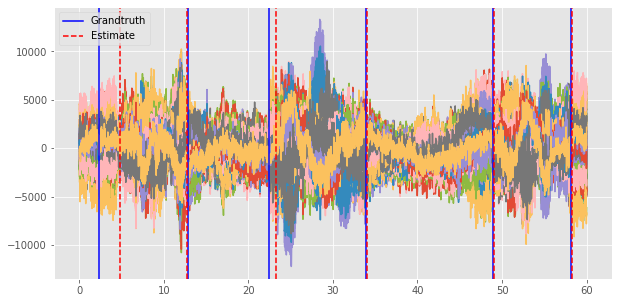

In [227]:
detRaw.UpdateEcpts(6)
print(detRaw)
detRaw.PlotEcpts(GT=gtSt03.cpts)

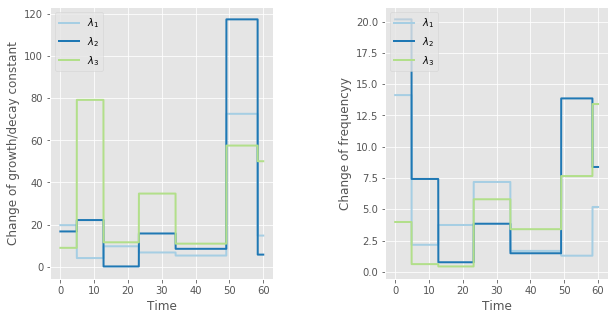

In [228]:
detRaw.PlotEigenCurve()

In [229]:
detRaw.kappas[detRaw.numchgs==6]

array([1.2972973 , 1.3003003 , 1.3033033 , 1.30630631, 1.30930931,
       1.31231231, 1.31531532, 1.31831832, 1.32132132, 1.32432432,
       1.32732733, 1.33033033, 1.33333333, 1.33633634, 1.33933934,
       1.34234234, 1.34534535, 1.34834835, 1.35135135, 1.35435435,
       1.35735736, 1.36036036, 1.36336336, 1.36636637, 1.36936937,
       1.37237237, 1.37537538, 1.37837838, 1.38138138])

## Detection on data with no HPF and no screening

In [14]:
detRawNo = TVDNDetect1(Ymat=dataN, dataType="MEG", 
                     saveDir="../results/MEGeye-st03",
                     fName="MEGmin",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     fct=paras.fct,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEGmin',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 6}


In [15]:
detRawNo()

/home/huaqingj/MyResearch/TVDN/pyTVDN/TVDNclass.py:266: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)


In [16]:
kappas = np.linspace(1, 4, 1000)
detRawNo.TuningKappa(kappas)

+-------------+---------------------------------------+--------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE         | Rank |
+-------------+---------------------------------------+--------------------+------+
|      6      | [ 592. 1531. 2776. 4107. 5893. 7000.] | 394.23064920541884 |  6   |
+-------------+---------------------------------------+--------------------+------+


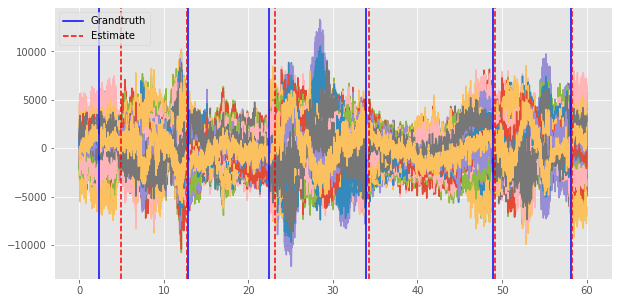

In [17]:
detRawNo.UpdateEcpts(6)
print(detRawNo)
detRawNo.PlotEcpts(GT=gtSt03.cpts, saveFigPath="../plots/MEG-eye-03-cpts.jpg")

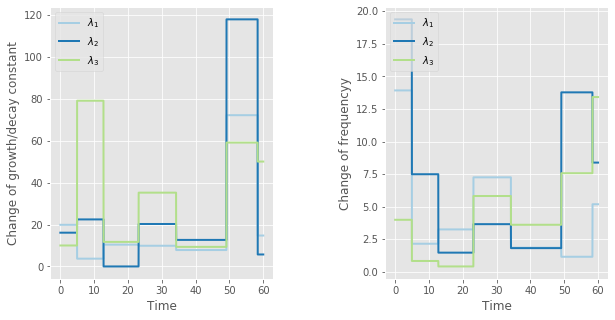

In [71]:
detRawNo.PlotEigenCurve(saveFigPath="../plots/MEG-eye-03-lam.jpg")

In [40]:
detRawNo.kappas[detRawNo.numchgs==6]

array([1.34234234, 1.34534535, 1.34834835, 1.35135135, 1.35435435,
       1.35735736, 1.36036036, 1.36336336, 1.36636637, 1.36936937,
       1.37237237, 1.37537538, 1.37837838, 1.38138138])

In [18]:
Amat = detRawNo.Amat
eigVals, eigVecs = np.linalg.eig(Amat)
print(np.where(np.cumsum(np.abs(eigVals))/np.sum(np.abs(eigVals)) >0.8)[0][0] + 1)

9


### Save results

In [18]:
def obtainwU(DetObj):
    eigVecs = DetObj.midRes.eigVecs[:, :DetObj.paras.r]
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    eigVals = DetObj.RecResCur.LamMs[:, kpidxs]
    wU = eigVecs.dot(eigVals)
    return wU

def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [217]:
wUst = obtainwU(detRawNo)
wUst = np.transpose(wUst)
abswUst = np.abs(wUst)
# save to npy file
with open("MEG03_abswU_full.npy", "wb") as f:
    np.save(f, abswUst)
with open("MEG03_wU_full.npy", "wb") as f:
    np.save(f, wUst)

abswUstMM = np.zeros_like(abswUst)
for i, col in enumerate(abswUst):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUstMM[i, :34] = lh
    abswUstMM[i, 34:] = rh
    #abswUstMM[i, :] = minmax(col)

In [218]:
import pandas as pd

fcR = pd.read_csv('../data/brain_plot_meg/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    lh = minmax(fcRar[:34])
    rh = minmax(fcRar[34:])
    fcRarrMM[i, :34] = lh
    fcRarrMM[i, 34:] = rh
    #fcRarrMM[i, :] = minmax(fcRar)

In [219]:
from collections import OrderedDict as odict
csvD = odict()
for i, name in enumerate(colNames):
    csvD[name] = abswUstMM[:, i]

csvD = pd.DataFrame(csvD)
csvD.to_csv("wU_minmax_st03.csv")

In [220]:
import scipy.stats as ss
from collections import defaultdict as ddict
corrs = ddict(list)
for absU in abswUstMM:
    for j, name in enumerate(rowNames):
        #corrs[name].append(ss.spearmanr(fcRarrMM[j, :], absU)[0])
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
    
corrsDF = pd.DataFrame(corrs)
corrsDF.to_csv("corrs_st03.csv")

In [221]:
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,0.039810,-0.139885,-0.033105,-0.067046,0.034914,0.067786,0.026806
1,0.234872,-0.062432,0.101527,0.133826,-0.296578,-0.198782,0.075855
2,0.157128,0.078965,-0.236521,0.105052,-0.153411,-0.212045,0.163961
3,0.055370,-0.145874,-0.035911,0.176819,-0.227367,-0.104455,0.164032
4,-0.191342,0.304155,-0.299326,0.035819,0.072748,-0.007448,0.090948
5,-0.125556,0.035269,-0.020030,0.054812,-0.031018,0.100071,-0.049639
6,0.290336,-0.043885,0.049413,-0.012134,-0.102951,-0.161712,0.002982


### Results for other ranks

In [203]:
#  spearsman rank 4
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.067743,-0.058275,-0.092624,0.124265,0.030438,0.048895,-0.112504
1,-0.038493,0.053091,-0.062574,0.177552,0.047826,0.103042,-0.010804
2,-0.060077,0.131290,-0.075110,0.140054,0.052286,0.066853,0.125777
3,-0.319336,0.352412,-0.147687,-0.285811,0.328005,0.037558,0.192357
4,-0.082258,0.155838,-0.101182,0.211507,0.082294,0.044748,0.166887
5,-0.143086,0.225538,-0.115549,0.192456,0.091236,-0.024600,0.259277
6,0.129533,-0.096127,-0.054707,-0.025898,-0.037691,-0.100315,-0.064734


In [201]:
#  pearson rank 4
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,0.024323,-0.124883,-0.021546,-0.058288,0.051245,0.092848,-0.011494
1,-0.095508,0.036216,-0.065135,-0.069350,0.067575,0.145736,-0.035018
2,-0.124265,0.044556,-0.099540,-0.095288,0.032802,0.068735,0.099914
3,-0.282849,0.167655,-0.185038,-0.239870,0.323723,0.024875,0.188664
4,-0.156616,0.139967,-0.149916,-0.019674,0.020123,0.074725,0.048883
5,-0.201405,0.227149,-0.199335,0.056362,0.014878,-0.009217,0.082218
6,0.227321,-0.146214,0.002512,-0.065070,0.000389,-0.061035,0.033862


In [181]:
#  pearson rank 8
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.013285,-0.068793,-0.008689,-0.140289,0.021919,0.122516,0.084090
1,0.336607,-0.078828,0.121041,0.267732,-0.278511,-0.227682,-0.128836
2,0.121324,-0.231432,-0.065475,0.104520,0.069979,-0.078890,-0.043691
3,0.166216,-0.150278,-0.034946,0.292272,-0.346598,-0.179434,0.117759
4,-0.214239,0.320824,-0.280356,0.029136,0.096175,0.023500,0.057869
5,-0.153591,0.044466,-0.050455,0.027926,-0.040032,0.080868,0.052738
6,0.294367,-0.039518,0.050586,-0.004186,-0.101843,-0.158959,-0.013492


In [179]:
#  spearrman rank 8
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.080796,0.025951,-0.047267,-0.009828,0.018790,0.084628,-0.012503
1,0.306216,-0.056892,0.146668,0.265852,-0.354104,-0.221568,-0.165777
2,0.128158,-0.336018,-0.118409,0.147571,-0.083861,-0.098784,-0.046184
3,0.098311,-0.233303,0.021452,0.215654,-0.399887,-0.251187,0.120159
4,-0.163140,0.294181,-0.172691,0.128498,0.212082,-0.008457,0.274566
5,-0.052498,0.040693,-0.039410,0.156859,-0.082956,0.005820,0.005074
6,0.183051,-0.054495,0.085984,-0.074282,-0.110049,-0.153681,-0.053160


In [166]:
#  spearrman rank 6
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.069783,-0.044397,-0.095829,0.068040,0.025591,0.037680,-0.065278
1,0.152088,-0.006264,0.115866,0.129060,-0.326702,-0.211986,0.010804
2,0.162861,-0.012981,-0.171879,0.251531,-0.056901,-0.225979,0.332279
3,0.013764,-0.209901,-0.004502,0.094392,-0.259688,-0.168060,0.155245
4,-0.150742,0.285930,-0.186672,0.141868,0.196295,-0.040884,0.312030
5,-0.021315,0.061536,-0.001158,0.205934,-0.050078,0.039424,-0.042107
6,0.170200,-0.061730,0.075595,-0.071085,-0.097507,-0.146137,-0.060340


In [164]:
# pearson rank 6
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,0.039810,-0.139885,-0.033105,-0.067046,0.034914,0.067786,0.026806
1,0.234872,-0.062432,0.101527,0.133826,-0.296578,-0.198782,0.075855
2,0.157128,0.078965,-0.236521,0.105052,-0.153411,-0.212045,0.163961
3,0.055370,-0.145874,-0.035911,0.176819,-0.227367,-0.104455,0.164032
4,-0.191342,0.304155,-0.299326,0.035819,0.072748,-0.007448,0.090948
5,-0.125556,0.035269,-0.020030,0.054812,-0.031018,0.100071,-0.049639
6,0.290336,-0.043885,0.049413,-0.012134,-0.102951,-0.161712,0.002982
